In [1]:
from PCB_class import PCB
from Component_class import Component, Pin
from Plots import plot_pcb
from NSGA_II_implementation import *
from Genetic_algorithms import *

import random as rnd

# Composition (components, pins, links) of the PCB to optimize

In [2]:
pin1_c1 = Pin(id="P1", relative_x=-5, relative_y=0)
pin2_c1 = Pin(id="P2", relative_x=5, relative_y=0)

comp1 = Component(
    id="C1",
    shape="rect",
    size_x=20, size_y=10,
    pins=[pin1_c1, pin2_c1],
    position=(21, 21),
    temp_gradient_params=(100, 15)
)

pin3_c2 = Pin(id="P3", relative_x=0, relative_y=-3)
pin4_c2 = Pin(id="P4", relative_x=0, relative_y=3)

comp2 = Component(
    id="C2",
    shape="circle",
    size_x=15, size_y=15,
    pins=[pin3_c2, pin4_c2],
    position=(20, 20),
    temp_gradient_params=(100, 15)
)

pin5_c3 = Pin(id="P5", relative_x=0, relative_y=-3)

comp3 = Component(
    id="C3",
    shape="rect",
    size_x=10, size_y=10,
    pins=[pin5_c3],
    position=(20, 20),
    temp_gradient_params=(10, 3)
)
links = [
        (("C1", "P2"), ("C2", "P3")),   # comp1.pin2 <--> comp2.pin3
        (("C3","P5"),("C2","P4")),
        (("C1","P1"), ("C3","P5"))
    ]

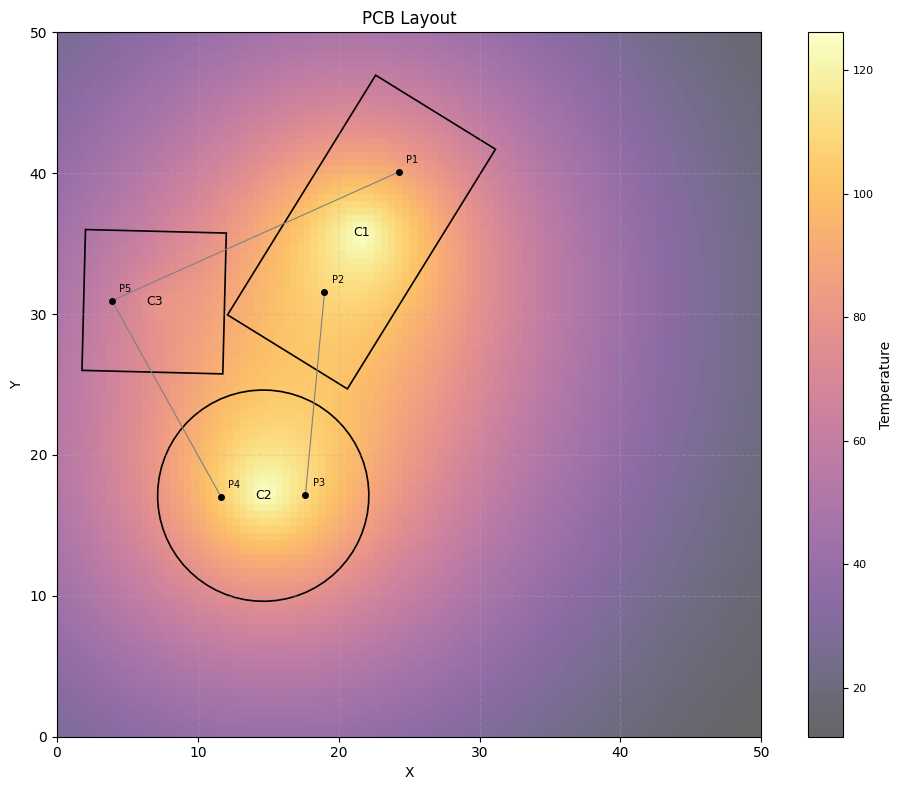

In [3]:
pcb1 = PCB(
        max_width=50,
        max_height=50,
        components=[comp1, comp2, comp3],
        links=links
    )
pcb1.random_placement()
pcb1.resolve_conflicts(max_iterations=100)
plot_pcb(pcb1, show_temp=True)


---

# Optimization via NSGA 2

### Objective functions selected for multi-objective:
 - minimize the total area occupied
 - minimize the total distance between pins (using the heuristic to not compute the actual routing)
 - minimize the max temperature in the board

In [21]:
# Genetic Algorithm parameters

number_of_generations = 50
population_size = 100
rotation_mutation_rate = 0.4
position_mutation_rate = 0.1
elitism_count = 10

In [22]:
pop = generate_random_population(pcb1, population_size)

for generation in range(number_of_generations):

    pop_objectives = [evaluate_objectives(pcb) for pcb in pop]

    fronts, ranks = fast_non_dominated_sort(pop_objectives, verbose=False)
    crowding = calculate_crowding_distance_for_population(pop, pop_objectives, fronts)

    offspring = []
    while len(offspring) < population_size:

        # selection of parents (via rank and then crowding distance)
        p1 = tournament_select(pop, ranks, crowding)
        p2 = tournament_select(pop, ranks, crowding)

        # crossover (swap 1 component between parents)
        child1, child2 = crossover(p1, p2, 1)

        # mutate rotation (less impactful) and position (very impactful)
        mutate_rotation(child1, rotation_mutation_rate)
        mutate_position(child1, position_mutation_rate)
        mutate_rotation(child2, rotation_mutation_rate)
        mutate_position(child2, position_mutation_rate)

        offspring.append(child1)
        offspring.append(child2)

    offspring = offspring[:population_size]


    offspring_objectives = [evaluate_objectives(pcb) for pcb in offspring]

    # elitism
    mixed_pop = pop + offspring
    mixed_obj = pop_objectives + offspring_objectives

    # select the next generation
    pop, _ = nsga2_select(mixed_pop, mixed_obj, population_size)


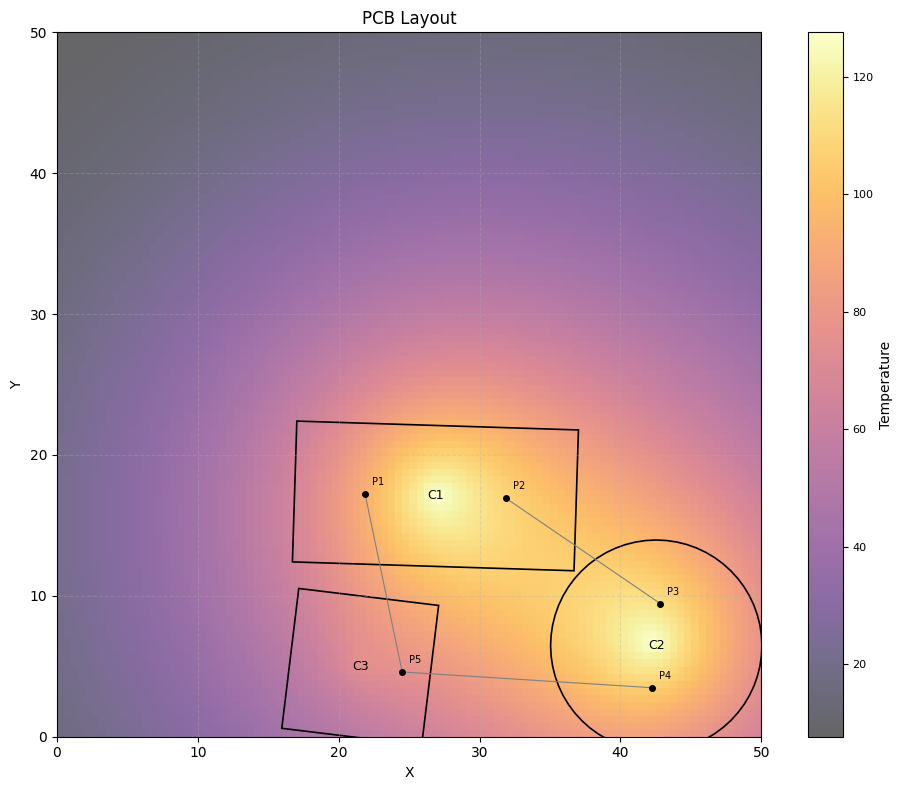

In [46]:
plot_pcb(rnd.sample(pop, 1)[0], show_temp=True)